# Config

In [ ]:
VERSION = 'shm_lr_1_10-epoch_final'
OVERWRITE_CHECKPOINT = False    
RECOVER_PAST_TRAINNING = True
TRAIN = False
# Rsp swin t from https://github.com/ViTAE-Transformer/ViTAE-Transformer-Remote-Sensing
# loss function imbalanced classes

import sys, os
RunningInCOLAB = 'google.colab' in sys.modules

BATCH_SIZE = 64
if RunningInCOLAB:
    BATCH_SIZE = 64

FEATURES = 17
IMG_SIZE = 224
LR = 1e-4
LR_STEP_SIZE = 1
GAMMA = 0.9
N_EPOCHS = 10
MODEL_ARCH = ['rsp-swin-t', 'rsp-resnet-50', 'swin_t_IMAGENET', 'resnet50_IMAGENET']

MODEL = 'rsp-swin-t'
#MODEL = 'rsp-resnet-50'


weights_models = {'rsp-swin-t': 'rsp-swin-t-ckpt.pth', 'swin_t_IMAGENET': 'IMAGENET1K_V1',
                      'rsp-resnet-50' : 'rsp-resnet-50-ckpt.pth', 'resnet50_IMAGENET':'' }

weights_filename = weights_models[MODEL]

config = {"BATCH_SIZE": BATCH_SIZE,"IMG_SIZE": IMG_SIZE,"LR": LR,"LR_STEP_SIZE": LR_STEP_SIZE,
          "GAMMA": GAMMA,"N_EPOCHS": N_EPOCHS,"VERSION": VERSION,"PRETRAIN_WEIGHTS": weights_filename}
      

# Set Environment

In [ ]:
if RunningInCOLAB:
    from google.colab import drive, files, runtime

    drive.mount('/content/drive', force_remount=True)
    !unzip -n /content/drive/MyDrive/Colab-Notebooks/datasets/planet.zip -d /dev/shm/ &> /dev/null;
    %clear
    checkpoint_path_dir = '/content/drive/MyDrive/Colab-Notebooks/checkpoints/'
    dataset_dir="/dev/shm/planet/"
    experiment_results = f'drive/MyDrive/Colab-Notebooks/results/{MODEL}_{VERSION}'
    %mkdir -p ${experiment_results}
else:
    home = os.environ['HOME']
    dataset_dir = home + "/UFMG/Thesis/datasets/planet"
    checkpoint_path_dir = home +'/UFMG/Thesis/Experiments/checkpoints/'
    experiment_results = home + f'/UFMG/Thesis/Experiments/results/{MODEL}_{VERSION}/'
    %mkdir -p ${experiment_results}

results_path = checkpoint_path_dir + f"train_results_{MODEL}_{VERSION}.pkl"
checkpoint_path = checkpoint_path_dir + f"{MODEL}_{VERSION}.pth"
weights_path = checkpoint_path_dir + f"{weights_filename}"          


Mounted at /content/drive
/bin/bash: module: No such file or directory


In [ ]:
if RunningInCOLAB:
    %pip install torch torchvision sklearn dill tqdm plotly matplotlib torchinfo opencv-python timm yacs seaborn kaleido
    %clear

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 548 kB 10.9 MB/s 
     |████████████████████████████████| 79.9 MB 144 kB/s 
     |████████████████████████████████| 182 kB 40.2 MB/s 
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=36bcc7f5565e7f8b27063fa5356a099fc4633a39d7302d9c3444e5afc31e570b
  Stored in directory: /root/.cache/pip/wheels/42/56/cc/4a8bf86613aafd5b7f1b310477667c1fca5c51c3ae4124a003
Successfully built sklearn


In [ ]:
!nvidia-smi -L

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
path = dataset_dir
path_train = os.path.join(path, "train-jpg")
path_test = os.path.join(path, "test-jpg")
total_train_files = len(os.listdir(path_train))
print(f"train files: {total_train_files}, "
    f"test files: {len(os.listdir(path_test))}")

train files: 40479, test files: 40669


# Libs

In [ ]:
from collections import Counter
from copy import copy, deepcopy
from glob import glob
from matplotlib import pyplot as plt
from PIL import Image
from plotly import graph_objects as go
from plotly.subplots import make_subplots
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, precision_recall_fscore_support, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from time import time
from torch import nn, Tensor
from torch.autograd import Variable
from torch.optim import AdamW, Adam
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from torchinfo import summary
from torchvision import transforms, models
from tqdm.notebook import tqdm
import threading
import cv2
import dill as pickle
import gc
import numpy as np  # Torch wrapper for Numpy
import os
import pandas as pd
import plotly.express as px
import plotly.figure_factory as ff
import random
import seaborn as sns
import threading
import timm
import torch
import torch.optim as optim

%matplotlib inline

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device: {device}")

device: cpu


In [ ]:
def clear_cache():
    if RunningInCOLAB:
        torch.cuda.empty_cache()
    gc.collect()

In [ ]:
def seed_everything(seed):
    """
    Seeds basic parameters for reproductibility of results

    Arguments:
        seed {int} -- Number of the seed
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(2022)

# EDA

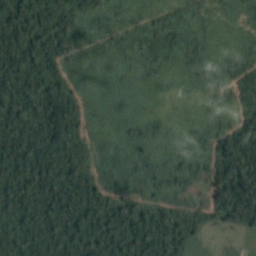

In [ ]:
display(Image.open(path_train+'/train_333.jpg').convert("RGB"))

In [ ]:
path_class = os.path.join(path, "train_classes.csv")
df_class = pd.read_csv(path_class)
print(df_class.shape)

(40479, 2)


In [ ]:
label_list = []
for tag_str in df_class.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)
# Histogram of label instances
#df_class[label_list].sum().sort_values().plot.bar()      

# Add onehot features for every label
for label in label_list:
    df_class[label] = df_class['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)
# Display head
df_class.head()

image_name                                       tags  haze  primary  \
0    train_0                               haze primary     1        1   
1    train_1            agriculture clear primary water     0        1   
2    train_2                              clear primary     0        1   
3    train_3                              clear primary     0        1   
4    train_4  agriculture clear habitation primary road     0        1   

   agriculture  clear  water  habitation  road  cultivation  slash_burn  \
0            0      0      0           0     0            0           0   
1            1      1      1           0     0            0           0   
2            0      1      0           0     0            0           0   
3            0      1      0           0     0            0           0   
4            1      1      0           1     1            0           0   

   cloudy  partly_cloudy  conventional_mine  bare_ground  artisinal_mine  \
0       0              0                  0            0               0   
1       0              0                  0            0               0   
2       0              0                  0            0               0   
3       0              0                  0            0               0   
4       0              0                  0            0               0   

   blooming  selective_logging  blow_down  
0         0                  0          0  
1         0                  0          0  
2         0                  0          0  
3         0                  0          0  
4         0                  0          0

In [ ]:
df_class["list_tags"] = df_class.tags.str.split(" ")
row_tags = df_class.list_tags.values
tags = [tag for row in row_tags for tag in row]
counter_tags = Counter(tags)
df_tags = pd.DataFrame(
    {"tag": counter_tags.keys(), "total": counter_tags.values()}
).sort_values("total")

fig = px.bar(df_tags, x="total", y="tag", orientation="h", color="total",)
title = 'Class distribution'
fig.update_layout(title="Tags distribution", width=600, height=400)
fig.show()
fig.write_image(experiment_results+title+".jpg")

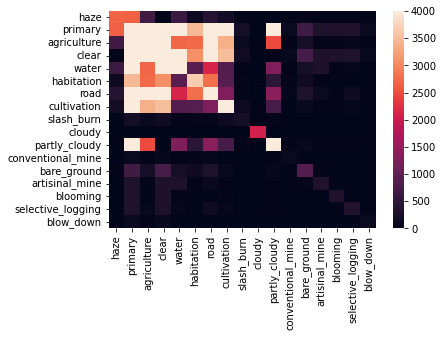

In [ ]:
def make_cooccurence_matrix(labels):
    numeric_df = df_class[labels]; 
    c_matrix = numeric_df.T.dot(numeric_df)
    title = 'Co-occurrence matrix'
    fig = sns.heatmap(c_matrix, vmax=4000)
    fig.get_figure().savefig(experiment_results+title+".jpg")
    return c_matrix
    
# Compute the co-ocurrence matrix
c_matrix = make_cooccurence_matrix(label_list)

In [ ]:
RARE_CLASSES = ["bare_ground", "selective_logging", "artisinal_mine", "blooming", "slash_burn", "blow_down", "conventional_mine"]
CLIMATE_CLASSES = ["clear", "partly_cloudly", "haze", "cloudy"]

## Train-Test split 80%-20%

In [ ]:
df_train, df_val = train_test_split(df_class, test_size=.2)
ds_train_size, ds_val_size = df_train['tags'].size, df_val['tags'].size
for rare_class in RARE_CLASSES:
    total_train = df_train.loc[df_train.tags.str.contains(rare_class)].shape[0]
    total_val = df_val.loc[df_val.tags.str.contains(rare_class)].shape[0]
    print(f"train {rare_class}: {100 * total_train / df_train.shape[0]:.4f}% ({total_train})")
    print(f"val {rare_class}: {100 * total_val / df_val.shape[0]:.4f}% ({total_val})\n")

train bare_ground: 2.0690% (670)
val bare_ground: 2.3715% (192)

train selective_logging: 0.7967% (258)
val selective_logging: 1.0128% (82)

train artisinal_mine: 0.8369% (271)
val artisinal_mine: 0.8399% (68)

train blooming: 0.8245% (267)
val blooming: 0.8029% (65)

train slash_burn: 0.5188% (168)
val slash_burn: 0.5064% (41)

train blow_down: 0.2254% (73)
val blow_down: 0.3088% (25)

train conventional_mine: 0.2470% (80)
val conventional_mine: 0.2470% (20)



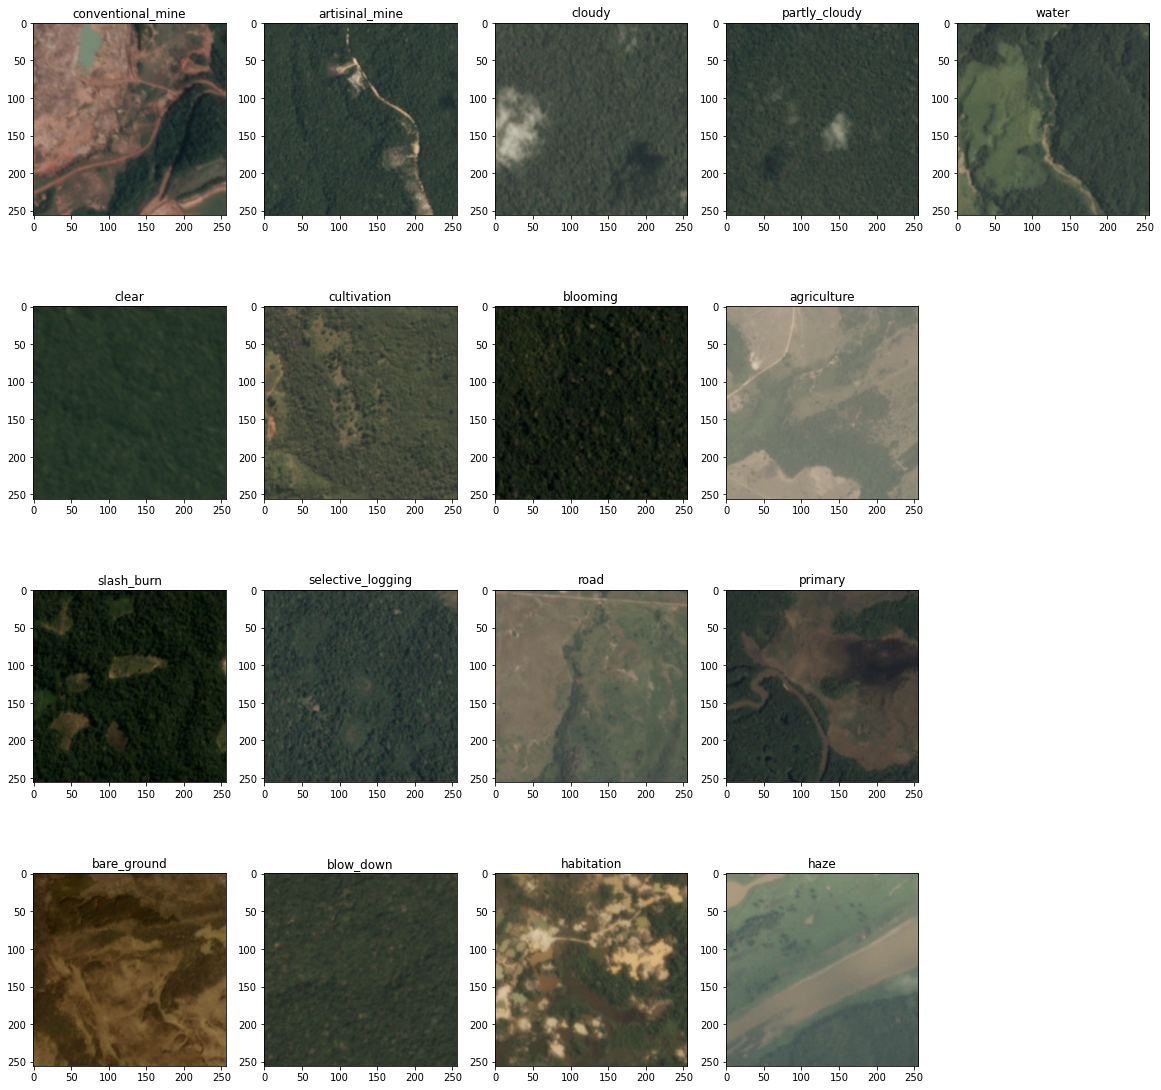

In [ ]:
all_tags = list(set(tags))
N_tags = len(all_tags)
fig, axes = plt.subplots(4, (N_tags//4)+1, figsize=(20, 20))
for idx, tag in enumerate(all_tags):
    filename = df_class.loc[df_class.tags.str.contains(tag)].image_name.values[random.randint(0,25)]
    img = cv2.imread(os.path.join(path_train, filename+".jpg"))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    idx_col = idx // 4
    idx_row = idx % 4
    axes[idx_row][idx_col].set_title(tag)
    axes[idx_row][idx_col].imshow(img)
axes[1][-1].remove()
axes[2][-1].remove()
axes[3][-1].remove()
title = 'Class Sampling'
plt.savefig(experiment_results+title+".jpg")

In [ ]:
def load_img(path_file):
    img = cv2.imread(path_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (100, 100), cv2.INTER_LINEAR).astype(float)
    img = cv2.normalize(img, None, 0.0, 1.0, cv2.NORM_MINMAX)
    img = img.reshape(1, -1)
    return img

In [ ]:
filenames = df_class.image_name.sample(600).values
path_files = [os.path.join(path_train, filename+".jpg")
              for filename in filenames]
X_train_sample = np.vstack([load_img(path_file) for path_file in path_files])
X_train_sample.shape

(600, 30000)

In [ ]:
def fetch_img(path_file, h, w):
    img = cv2.imread(path_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (h*2, w*2), cv2.INTER_LINEAR)
    return img

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



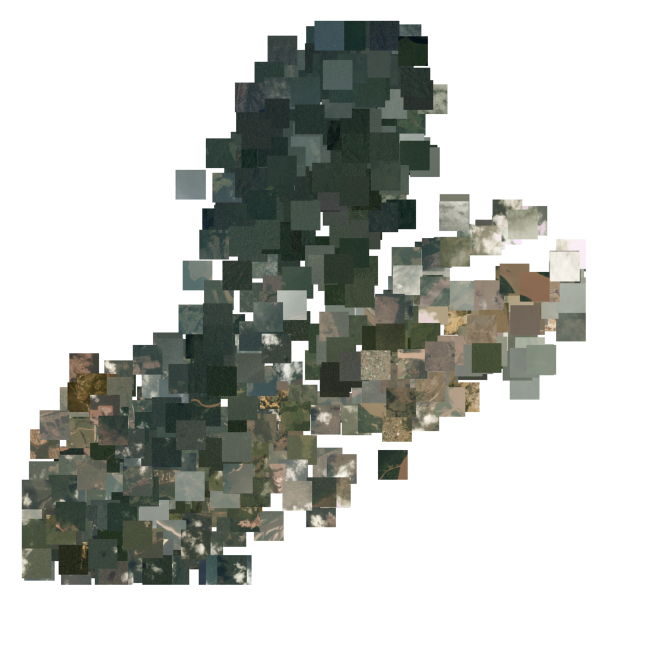

In [ ]:
def tsne_analysis():

    tsne = TSNE(
        n_components=2,
        init="random",
        random_state=101,
        method="barnes_hut",
        n_iter=500,
        verbose=0,
    )
    X_embedded = tsne.fit_transform(X_train_sample)

    size_img = 1000
    offset_img = 50
    h = w = int(offset_img / 2)

    X_scaled = (X_embedded - X_embedded.min(0)) / (X_embedded.max(0) - X_embedded.min(0))
    X_scaled = (X_scaled * size_img).astype(int)
    X_scaled = np.clip(X_scaled, offset_img, size_img-offset_img)

    img_tsne = np.ones((size_img+2*offset_img, size_img+2 * offset_img, 3), dtype=np.uint8) * 255
    for idx in range(X_scaled.shape[0]):
        x, y = X_scaled[idx][0], X_scaled[idx][1]
        img = fetch_img(path_files[idx], h, w)
        img_tsne[x-w:x+w, y-h:y+h, :] = img

    fig = plt.figure(figsize=(12, 12))
    plt.axis("off")
    title = 'TSNE Clustering'
    plt.savefig(experiment_results+title+".png")
    return plt.imshow(img_tsne)

tsne_analysis()


# Dataset loader

In [ ]:
# create image augmentations
transform_train = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], # Imagenet normalization
        )                                                          # TODO: Normalize from the current dataset
])

transform_val = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225],
        )
])

In [ ]:
class AmazonDatasetError(Exception):
    pass


class AmazonDataset(Dataset):
    def __init__(self, df, ohe_tags, transform, path, is_train=True, idx_tta=None):
        super().__init__()
        self.df = df
        self.ohe_tags = ohe_tags
        self.transform = transform_train
        if isinstance(path, str):
            self.paths = [path]
        elif isinstance(path, (list, tuple)):
            self.paths = path
        else:
            raise AmazonDatasetError(f"Path type must be str, list or tuple, got: {type(path)}")
        self.is_train = is_train
        self.idx_tta = idx_tta

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        filename = self.df.iloc[idx].image_name + ".jpg"
        for path in self.paths:
            if filename in os.listdir(path):
                file_path = os.path.join(path, filename)
                break
        else:
            raise AmazonDatasetError(f"Can't fetch {filename} among {self.paths}")
        image = Image.open(file_path).convert("RGB")
        label = self.ohe_tags[idx]
        return image, label

    def collate_fn(self, batch):
        imgs, labels = [], []
        for (img, label) in batch:
            img = self.transform(img)
            img.permute(2, 0, 1)
            imgs.append(img[None])
            labels.append(label[None])
        imgs = torch.cat(imgs).float()
        labels = torch.cat(labels).float()
        return imgs, labels

    def load_img(self, idx, ax=None):
        img, ohe_label = self[idx]
        label = self.df.iloc[idx].tags
        title = f"{label} - {ohe_label} - {self.transform(img).shape}"
        if ax is None:
            plt.imshow(img)
            plt.title(title)
        else:
            ax.imshow(img)
            ax.set_title(title)


In [ ]:
def get_data(df_train, df_val):

    encoder = MultiLabelBinarizer()
    ohe_tags_train = torch.tensor(encoder.fit_transform(df_train.list_tags.values))
    ohe_tags_val = torch.tensor(encoder.transform(df_val.list_tags.values))

    ds_train = AmazonDataset(df_train, ohe_tags_train,
                             transform_train, path=path_train)
    ds_val = AmazonDataset(df_val, ohe_tags_val,
                           transform_val, path=path_train)

    sample_weights = ohe_tags_train.shape[0]/ohe_tags_train.sum(axis=0)
    sample_weights = sample_weights.double()
    sampler = torch.utils.data.WeightedRandomSampler(
        sample_weights, len(sample_weights))

    dl_train = DataLoader(
        ds_train,
        batch_size=BATCH_SIZE,
        collate_fn=ds_train.collate_fn,
        # sampler=sampler,
        shuffle=True,
        prefetch_factor=8,
        pin_memory=True,
        num_workers=2,
        drop_last=True

    )
    dl_val = DataLoader(
        ds_val,
        batch_size=BATCH_SIZE,
        shuffle=True,
        collate_fn=ds_val.collate_fn,
        prefetch_factor=4,
        pin_memory=True,
        num_workers=2,
        drop_last=True
    )

    return ds_train, ds_val, dl_train, dl_val, encoder, ohe_tags_train

In [ ]:
ds_train, ds_val, dl_train, dl_val, encoder, ohe_tags_train = get_data(df_train, df_val)
classes = encoder.classes_
classes = list(classes)
def unitest_loader():
  imgs, labels = next(iter(dl_train))
  print(imgs.shape, labels.shape)

  imgs, labels = next(iter(dl_val))
  print(imgs.shape, labels.shape)

#unitest_loader()

### Utils

In [ ]:
def load_checkpoint(filename):
    try:
        checkpoint = torch.load(filename, map_location=torch.device(device))
        print(checkpoint.keys())
        epoch = checkpoint['epoch']
        model_state = checkpoint['model']
        optimizer_state = checkpoint['optimizer']
        lr_scheduler_state = checkpoint['lr_scheduler']
        max_accuracy = checkpoint['max_accuracy']
        epoch = checkpoint['epoch']
        #config = checkpoint['config']
        return checkpoint, epoch, model_state, optimizer_state, lr_scheduler_state, max_accuracy
    except:
        print("Not able to load checkpoint ",filename)


def load_results(filename):
    try:
        results = dict()
        results = pickle.load(open(filename,"rb"))
        score = results['score']
        loss = results['loss']
        y_epochs = results['y']
        Y_thresh = results['Y_thresh']
        configs = results['config']
        epochs = results['epoch']
        max_accuracy = results['max_accuracy']

        return results, score, loss, y_epochs, Y_thresh, configs, epochs, max_accuracy

    except Exception as e:
        print("Not able to load results")
        print(e)  


def remove_file(path):
    if OVERWRITE_CHECKPOINT:
        try:
            os.remove(path)
            print(f"File {path} removed")
            return
        except Exception as e:
            print(e) 
    print(f"Not able to remove {path}")  

def save_overwrite_checkpoints(checkpoint, file):
    remove_file(file)
    torch.save(checkpoint, file)
    print(f"File {file} updated")


def save_overwrite_results(results, file):
    remove_file(file)
    pickle.dump(results, open(file, "wb+"))    
    print(f"File {file} updated")

def print_arch():
  print([module for module in model.modules() if not isinstance(module, nn.Sequential)])
    
def print_weights():
    kl = list()
    #unfreeze_param = ["relative_position_index", "relative_coords_table", "attn_mask", "head", "relative_position_bias_table", "absolute_pos_embed"]
    unfreeze_param = ["head", "layers.3.blocks.1.mlp, layers.3.downsample.norm"]
    unfreeze_param = ["layers.3.blocks.1."]
    #unfreeze_param = ["head"]
    for k, v in model.state_dict().items():
        #v.requires_grad = False
        print(f"{k} requires grad {v.float().requires_grad}")
        for parameter in unfreeze_param:
            if parameter in k:
                freeze=False
                v=v.float()
                print(k,v)
                #v.requires_grad = True 
                print(f"unfreeze {k}")
                break
            freeze=True

        if freeze:
            #v.requires_grad = freeze
            kl.append(k)
            #print( k)  


# Model

## Loading pre-trained weights/checkpoints

In [ ]:
if RECOVER_PAST_TRAINNING:
    checkpoint, epoch, model_state, optimizer_state, lr_scheduler_state, max_accuracy = load_checkpoint(checkpoint_path)
    results, score, loss, y_epochs, Y_thresh, configs, epochs, max_accuracy = load_results(results_path)
    print("recover_training")
else:
    if MODEL == 'resnet50_IMAGENET':
        model = models.resnet.resnet50(weights='IMAGENET1K_V1')
        model_state = model.state_dict()
    elif MODEL == 'swin_t_IMAGENET':
        model = models.swin_transformer.swin_t(weights='IMAGENET1K_V1')
        model_state = model.state_dict()
    else:
        checkpoint, epoch, model_state, optimizer_state, lr_scheduler_state, max_accuracy = load_checkpoint(weights_path)
    results = {}

dict_keys(['epoch', 'model', 'optimizer', 'loss', 'max_accuracy', 'best_loss_val', 'lr_scheduler', 'config'])
recover_training


In [ ]:
def build_model_resnet_50(model_state):
    #https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

    model = models.resnet50()
    model.fc = nn.Sequential(
      nn.Linear(2048, 17), # 512 for resnet18 or 2048 for resnet 50
      nn.Sigmoid()
    )     

    if RECOVER_PAST_TRAINNING:
        info = model.load_state_dict(model_state, strict=True)
        return model.to(device)

    del model_state['fc.weight']
    del model_state['fc.bias']

    info = model.load_state_dict(model_state, strict=False)

    #for param in model.parameters():
    #    param.require_grad = False

    return model.to(device)


if MODEL == 'rsp-resnet-50':
    model = build_model_resnet_50(model_state)
    clear_cache()

In [ ]:
def build_model_swan_t(model_state):
    num_classes = 17
    swin_embed_dim = 768

    model = timm.models.swin_tiny_patch4_window7_224()

    if RECOVER_PAST_TRAINNING:
        model.head = nn.Linear(swin_embed_dim, num_classes)
        model = torch.nn.Sequential(model, torch.nn.Sigmoid())
        info = model.load_state_dict(model_state, strict=True)
        clear_cache()
        return model.to(device)

    state_dict = model_state

    # assuming that the head layer has 768 neurons, otherwise change it
    model.head = nn.Linear(swin_embed_dim, num_classes)
    #torch.nn.Sequential(model, torch.nn.Sigmoid())

    model = model.to(device)
    state_dict = model.state_dict()

    # delete relative_position_index since we always re-init it
    relative_position_index_keys = [k for k in state_dict.keys() if "relative_position_index" in k]
    for k in relative_position_index_keys:
        del state_dict[k]

    # delete relative_coords_table since we always re-init it
    relative_position_index_keys = [k for k in state_dict.keys() if "relative_coords_table" in k]
    for k in relative_position_index_keys:
        del state_dict[k]

    # delete attn_mask since we always re-init it
    attn_mask_keys = [k for k in state_dict.keys() if "attn_mask" in k]
    for k in attn_mask_keys:
        del state_dict[k]

    state_dict = model_state
    torch.nn.init.constant_(model.head.bias, 0.)
    torch.nn.init.constant_(model.head.weight, 0.)

    del state_dict['head.weight']
    del state_dict['head.bias']

    info = model.load_state_dict(state_dict, strict=False)
    print(info)
    model.head = nn.Linear(swin_embed_dim, num_classes)
    model = torch.nn.Sequential(model, torch.nn.Sigmoid())
 

    return model.to(device)


if MODEL == 'rsp-swin-t' :
    clear_cache()
    model = build_model_swan_t(model_state)



/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning:

torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)



# Train setup

In [ ]:
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(FocalLoss, self).__init__()

    def forward(self, inputs, targets, alpha=0.8, gamma=2, smooth=1):     
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #first compute binary cross-entropy 
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        BCE_EXP = torch.exp(-BCE)
        focal_loss = alpha * (1-BCE_EXP)**gamma * BCE
                       
        return focal_loss.to(device)

class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
lr_scheduler = ReduceLROnPlateau(optimizer, factor=0.1, verbose=True, patience=1,
                                mode='min')
early_stopper = EarlyStopper(patience=2)
# https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html
sample_weights = ohe_tags_train.shape[0]/ohe_tags_train.sum(axis=0) - 1
sample_weights = sample_weights.double().to(device)
#loss_fn = nn.BCELoss(weight=sample_weights)  # Binary Cross Entropy
#loss_fn = nn.BCELoss()  # Binary Cross Entropy
loss_fn = FocalLoss()
sample_weights

tensor([2.2920e+00, 1.1849e+02, 4.7333e+01, 1.2028e+02, 4.4260e+02, 4.2915e-01,
        1.8299e+01, 4.0379e+02, 8.1143e+00, 1.0143e+01, 1.3794e+01, 4.5299e+00,
        7.9505e-02, 4.0214e+00, 1.2452e+02, 1.9176e+02, 4.4471e+00],
       dtype=torch.float64)

### Batch fit/validate

In [ ]:
def fit_batch(X, Y, model, loss_fn, optimizer):
    model.train()
    optimizer.zero_grad()
    Y_hat = model(X.to(device))
    batch_loss = loss_fn(Y_hat, Y.to(device))
    batch_loss.backward()
    optimizer.step()
    Y_hat = Y_hat.detach()

    return Y_hat, batch_loss.item()


@torch.no_grad()
def compute_val_loss(X, Y, model, loss_fn):
    model.eval()
    Y_hat = model(X.to(device))
    batch_loss = loss_fn(Y_hat, Y.to(device))
    Y_hat = Y_hat.detach()

    return Y_hat, batch_loss.item()
# Test batch train

def unit_test_batch_train():
    clear_cache()
    X, Y = next(iter(dl_train))
    model.train()
    optimizer.zero_grad()
    print(X.shape)
    print(Y.shape)
    Y_hat = model(X.to(device))
    Y_hat[Y_hat < 0]
    batch_loss = loss_fn(Y_hat, Y.to(device))
    Y_hat = Y_hat.detach()
    clear_cache()

    
#unit_test_batch_train()

In [ ]:
def init_arrays(train_baches_epoch, val_baches_epoch):
    train_baches_epoch, val_baches_epoch = int(train_baches_epoch), int(val_baches_epoch)
    loss = dict()
    loss["train"] = np.zeros((N_EPOCHS,train_baches_epoch))
    loss["val"] = np.zeros((N_EPOCHS,train_baches_epoch))
    lr = np.zeros((N_EPOCHS,train_baches_epoch))
    score = dict()
    score["val"] = np.zeros(N_EPOCHS)
    score["train"] = np.zeros(N_EPOCHS)

    y_epoch = {'train': dict(), 'val': dict()}
    y_epoch["train"]["label"] = torch.zeros((N_EPOCHS, train_baches_epoch, BATCH_SIZE, FEATURES))
    y_epoch["train"]["pred"] = torch.zeros((N_EPOCHS, train_baches_epoch, BATCH_SIZE, FEATURES))
    y_epoch["val"]["label"] = torch.zeros((N_EPOCHS, val_baches_epoch, BATCH_SIZE, FEATURES))
    y_epoch["val"]["pred"] = torch.zeros((N_EPOCHS, val_baches_epoch, BATCH_SIZE, FEATURES))

    return y_epoch, score, loss, lr
    
train_steps, val_steps = ds_train_size//BATCH_SIZE, ds_val_size//BATCH_SIZE
y_epoch, score, loss, lr = init_arrays(train_steps, val_steps)
print(train_steps)
print(y_epoch["train"]["label"][N_EPOCHS-1][train_steps-1][BATCH_SIZE-1][FEATURES-1])

505
tensor(0.)


In [ ]:
def eval_score(Y_true:Tensor, Y_pred:Tensor, threshold:float):
    Y_true = Y_true.cpu().numpy().reshape((-1,FEATURES))
    Y_pred = (Y_pred.cpu().numpy() > .2).astype(float).reshape((-1,FEATURES))
    return fbeta_score(Y_true,Y_pred,beta=2, average="samples")

t1, t2 = torch.zeros(FEATURES), torch.zeros(FEATURES)
t1[4], t2[7] = 1, 1
Y_true = torch.cat([t1,t2])
Y_pred = torch.cat([t2,t1])*0.8
print(Y_true)
print(Y_pred)
eval_score(Y_true, Y_pred, 0.5)

tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.8000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.8000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])


0.0

# Train

In [ ]:
def train_model(dl_train, dl_val, version, model, optimizer, loss_fn, lr_scheduler, results, checkpoint):
    train_steps, val_steps = ds_train_size//BATCH_SIZE, ds_val_size//BATCH_SIZE

    y_epoch, score, loss, lr = init_arrays(train_steps, val_steps)
    epoch_start = 0
    if results and RECOVER_PAST_TRAINNING:
        train_results = deepcopy(results)
        epoch_start = checkpoint['epoch']
        best_score_val = train_results["score_val"]
        lr_scheduler = checkpoint['lr_scheduler']
        
    Y_val, Y_hat = torch.zeros(FEATURES), torch.zeros(FEATURES)
    best_loss_val, best_score_val = torch.inf, 0
    Y_thresh_val = 0.2
    batch_loss = torch.inf
    for epoch in range(epoch_start, N_EPOCHS):

        for idx, (X, Y) in enumerate(tqdm(dl_train, leave=False)):
            Y_hat, batch_loss = fit_batch(X, Y, model, loss_fn, optimizer)
            loss["train"][epoch][idx] = batch_loss
            y_epoch["train"]["pred"][epoch][idx] = Y_hat
            y_epoch["train"]["label"][epoch][idx] = Y
            if idx > 0 and idx % 30 == 0:
                avg_loss = loss["train"][epoch][idx-LR_STEP_SIZE:idx+1].mean()
                it_score = eval_score(Y,Y_hat,Y_thresh_val)
                print(f'Train Loss: {avg_loss} score:{it_score}')
            #break

        for idx, (X, Y) in enumerate(tqdm(dl_val, leave=False)):
            Y_hat, batch_loss = compute_val_loss(X, Y, model, loss_fn)
            loss["val"][epoch][idx] = batch_loss
            y_epoch["val"]["pred"][epoch][idx] = Y_hat
            y_epoch["val"]["label"][epoch][idx] = Y
            #break
        

        score['train'][epoch] = eval_score(y_epoch["train"]["label"][epoch],
                                          y_epoch["train"]["pred"][epoch], Y_thresh_val)
        score['val'][epoch] = eval_score(y_epoch["val"]["label"][epoch],
                                        y_epoch["val"]["pred"][epoch], Y_thresh_val)

        avg_loss_train = loss["train"][epoch].mean()
        avg_loss_val = loss["val"][epoch].mean()
        lr[epoch][idx] = optimizer.param_groups[0]['lr']
        lr_scheduler.step(metrics=avg_loss_val)

        print(
            f"epoch: {epoch}/{N_EPOCHS} -- train loss: {avg_loss_train}, "
            f"val loss: {avg_loss_val}"
            f" -- train fbeta_score: {score['train'][epoch]}, "
            f"val fbeta_score: {score['val'][epoch]}"
        )

        checkpoint = {
            'epoch': epoch,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'loss': avg_loss_val,
            'max_accuracy': best_score_val,
            'best_loss_val': best_loss_val,
            'lr_scheduler': lr_scheduler.state_dict(),
            'config': config
        }

        results = {
            "loss": loss,
            "score": score,
            "y": y_epoch,
            'epoch': epoch,
            'best_loss_val': avg_loss_val,
            'max_accuracy': best_score_val,
            'config': config,
            'Y_thresh' : Y_thresh_val,
            'lr':lr
        }

        if avg_loss_val <= best_loss_val:
            save_overwrite_checkpoints(checkpoint, checkpoint_path)
        save_overwrite_results(results, results_path)

        best_loss_val = avg_loss_val if avg_loss_val < best_loss_val else best_loss_val
        best_score_val = score['val'][epoch] if best_score_val < score['val'][epoch] else best_score_val
        
        if early_stopper.early_stop(score['val'][epoch]):             
           pass
           #break

        #break

if TRAIN:
    clear_cache()
    train_model(dl_train, dl_val, VERSION, model, optimizer, loss_fn, lr_scheduler, results, checkpoint)


### Train Log swin_T

```
Train Loss: 0.00837220554240048 score:0.7983116912958823
Train Loss: 0.0035183201543986797 score:0.8648431428516324
Train Loss: 0.002047233982011676 score:0.8812302095723694
Train Loss: 0.002686640014871955 score:0.8711037256303638
Train Loss: 0.0024156044819392264 score:0.8629156730875234
Train Loss: 0.0014770320849493146 score:0.9054874816909682
Train Loss: 0.001005996688036248 score:0.9064428952490724
Train Loss: 0.0008538376714568585 score:0.9405002992301028
Train Loss: 0.0012196531461086124 score:0.9223134544822407
Train Loss: 0.0008637745049782097 score:0.9360459885860102
Train Loss: 0.0008390961156692356 score:0.9283906254826014
Train Loss: 0.0008131027570925653 score:0.8926074266147797
Train Loss: 0.0008494713401887566 score:0.8814693053711182
Train Loss: 0.001410484779626131 score:0.9224614280565567
Train Loss: 0.000951706460909918 score:0.9192521463666166
Train Loss: 0.0007105076219886541 score:0.9250923383572223

epoch: 0/10 -- train loss: 0.0027554367157448505, val loss: 0.00017473060026243882 -- train fbeta_score: 0.888137276668051, val fbeta_score: 0.9207448090791467
Not able to remove /content/drive/MyDrive/Colab-Notebooks/checkpoints/rsp-swin-t_shm_lr_1_10-epoch_final.pth
File /content/drive/MyDrive/Colab-Notebooks/checkpoints/rsp-swin-t_shm_lr_1_10-epoch_final.pth updated
Not able to remove /content/drive/MyDrive/Colab-Notebooks/checkpoints/train_results_rsp-swin-t_shm_lr_1_10-epoch_final.pkl
File /content/drive/MyDrive/Colab-Notebooks/checkpoints/train_results_rsp-swin-t_shm_lr_1_10-epoch_final.pkl updated

Train Loss: 0.0011550964845810086 score:0.9054205358900584
Train Loss: 0.00064347535953857 score:0.9206925281076682
Train Loss: 0.0004109951405553147 score:0.9116138958740062
Train Loss: 0.0007156809733714908 score:0.8982922607376328
Train Loss: 0.0011023454135283828 score:0.9192674519729858
Train Loss: 0.0004192081978544593 score:0.9390518811564608
Train Loss: 0.0007659387774765491 score:0.8998701114956352
Train Loss: 0.000503863557241857 score:0.919833950985076
Train Loss: 0.0005040410032961518 score:0.9323070223442709
Train Loss: 0.0006498376897070557 score:0.9222071297732112
Train Loss: 0.0005744472437072545 score:0.9156103829091445
Train Loss: 0.0003830307687167078 score:0.939521581511955
Train Loss: 0.0003605299425544217 score:0.9240713267405403
Train Loss: 0.0003782280837185681 score:0.9444660216694065
Train Loss: 0.0006577915919478983 score:0.9095666461457145
Train Loss: 0.0004451624408829957 score:0.9279743245387908

epoch: 1/10 -- train loss: 0.0006246229559920802, val loss: 0.00014166233811578206 -- train fbeta_score: 0.9224825473617588, val fbeta_score: 0.9269507444489615
Not able to remove /content/drive/MyDrive/Colab-Notebooks/checkpoints/rsp-swin-t_shm_lr_1_10-epoch_final.pth
File /content/drive/MyDrive/Colab-Notebooks/checkpoints/rsp-swin-t_shm_lr_1_10-epoch_final.pth updated
Not able to remove /content/drive/MyDrive/Colab-Notebooks/checkpoints/train_results_rsp-swin-t_shm_lr_1_10-epoch_final.pkl
File /content/drive/MyDrive/Colab-Notebooks/checkpoints/train_results_rsp-swin-t_shm_lr_1_10-epoch_final.pkl updated

Train Loss: 0.0004876529274042696 score:0.9342297245481341
Train Loss: 0.0005253604904282838 score:0.9149329762745722
Train Loss: 0.0007454768929164857 score:0.8974137770654956
Train Loss: 0.0004441344935912639 score:0.9256411400832756
Train Loss: 0.0005731221754103899 score:0.9127379959010904
Train Loss: 0.0008376766199944541 score:0.9420982038955626
Train Loss: 0.0005336044341675006 score:0.944408847931187
Train Loss: 0.00028991779254283756 score:0.934769635547757
Train Loss: 0.0005254931020317599 score:0.9083273970530887
Train Loss: 0.0004947838024236262 score:0.9003039488428719
Train Loss: 0.0007289206550922245 score:0.8857582297296014
Train Loss: 0.00022452025586972013 score:0.9328708088672207
Train Loss: 0.0006310981116257608 score:0.8990913773385081
Train Loss: 0.0003082185430685058 score:0.9359960825342744
Train Loss: 0.0007270191272255033 score:0.8856579191740195
Train Loss: 0.0003339246322866529 score:0.9203270117545936

epoch: 2/10 -- train loss: 0.0005151882692756556, val loss: 0.0001345454879009423 -- train fbeta_score: 0.9259230592961974, val fbeta_score: 0.923371376545482
Not able to remove /content/drive/MyDrive/Colab-Notebooks/checkpoints/rsp-swin-t_shm_lr_1_10-epoch_final.pth
File /content/drive/MyDrive/Colab-Notebooks/checkpoints/rsp-swin-t_shm_lr_1_10-epoch_final.pth updated
Not able to remove /content/drive/MyDrive/Colab-Notebooks/checkpoints/train_results_rsp-swin-t_shm_lr_1_10-epoch_final.pkl
File /content/drive/MyDrive/Colab-Notebooks/checkpoints/train_results_rsp-swin-t_shm_lr_1_10-epoch_final.pkl updated

Train Loss: 0.0003092593397013843 score:0.9524651823440977
Train Loss: 0.0008275195141322911 score:0.9063724452730608
Train Loss: 0.00032903697137953714 score:0.9399840285948932
Train Loss: 0.00042878503154497594 score:0.9241634740773401
Train Loss: 0.0003213706368114799 score:0.9198559201147869
Train Loss: 0.0006348513124976307 score:0.9152486850585986
Train Loss: 0.0004347568246885203 score:0.9211651891254935
Train Loss: 0.0007062686927383766 score:0.9073798761398242
Train Loss: 0.000282033666735515 score:0.9333817456135904
Train Loss: 0.00023497614165535197 score:0.9497991072759295
Train Loss: 0.0005365068500395864 score:0.922533310298224
Train Loss: 0.0005157562409294769 score:0.9319631202752716
Train Loss: 0.00040950122638605535 score:0.9304503405563229
Train Loss: 0.00027885650342796 score:0.9409649157351363
Train Loss: 0.00035905203549191356 score:0.9423019357520132
Train Loss: 0.00046082341577857733 score:0.9341015926623581

epoch: 3/10 -- train loss: 0.00044658390449539825, val loss: 0.00013024401421644864 -- train fbeta_score: 0.9290898098967625, val fbeta_score: 0.9259331295264717
Not able to remove /content/drive/MyDrive/Colab-Notebooks/checkpoints/rsp-swin-t_shm_lr_1_10-epoch_final.pth
File /content/drive/MyDrive/Colab-Notebooks/checkpoints/rsp-swin-t_shm_lr_1_10-epoch_final.pth updated
Not able to remove /content/drive/MyDrive/Colab-Notebooks/checkpoints/train_results_rsp-swin-t_shm_lr_1_10-epoch_final.pkl
File /content/drive/MyDrive/Colab-Notebooks/checkpoints/train_results_rsp-swin-t_shm_lr_1_10-epoch_final.pkl updated

Train Loss: 0.0001965928022400476 score:0.9364830804301907
Train Loss: 0.00025388356880284846 score:0.9448977760903312
Train Loss: 0.0003764382272493094 score:0.925782717910959
Train Loss: 0.00047853989235591143 score:0.922197832287859
Train Loss: 0.0006261778326006606 score:0.9407791963610219
Train Loss: 0.000187712321348954 score:0.9508837729196186
Train Loss: 0.0006152656860649586 score:0.9024227623095971
Train Loss: 0.00025173249741783366 score:0.940230636760363
Train Loss: 0.0004919841449009255 score:0.9457663265088138
Train Loss: 0.0007616538496222347 score:0.9163665759563009
Train Loss: 0.00034888790105469525 score:0.9104382717358936
Train Loss: 0.00043089127575512975 score:0.9172228036530149
Train Loss: 0.00045090009371051565 score:0.9134020881202272
Train Loss: 0.0005922825948800892 score:0.9247879153352658
Train Loss: 0.0005130997888045385 score:0.9474828777744131
Train Loss: 0.0003760282270377502 score:0.9554457618566075

epoch: 4/10 -- train loss: 0.0003987514189995438, val loss: 0.00012947871517747327 -- train fbeta_score: 0.9317154654249855, val fbeta_score: 0.9259306931685046
Not able to remove /content/drive/MyDrive/Colab-Notebooks/checkpoints/rsp-swin-t_shm_lr_1_10-epoch_final.pth
File /content/drive/MyDrive/Colab-Notebooks/checkpoints/rsp-swin-t_shm_lr_1_10-epoch_final.pth updated
Not able to remove /content/drive/MyDrive/Colab-Notebooks/checkpoints/train_results_rsp-swin-t_shm_lr_1_10-epoch_final.pkl
File /content/drive/MyDrive/Colab-Notebooks/checkpoints/train_results_rsp-swin-t_shm_lr_1_10-epoch_final.pkl updated

Train Loss: 0.0003421149158384651 score:0.9242279331386622
Train Loss: 0.0002006179711315781 score:0.9439246555884421
Train Loss: 0.00015116170470719226 score:0.9708460025110879
Train Loss: 0.00020571882487274706 score:0.9514039418336293
Train Loss: 0.00036095312680117786 score:0.9426081080377955
Train Loss: 0.00032012901647249237 score:0.9452984938448205
Train Loss: 0.0003612208383856341 score:0.9311306719974399
Train Loss: 0.0004094837495358661 score:0.9532443467448621
Train Loss: 0.00027692955336533487 score:0.9325728130953799
Train Loss: 0.0003465467452770099 score:0.9327962127088414
Train Loss: 0.0003976551724917954 score:0.9122022977014028
Train Loss: 0.0003065528435399756 score:0.9415127010870097
Train Loss: 0.00022173047182150185 score:0.948478872536777
Train Loss: 0.00026115078071597964 score:0.9307737959762479
Train Loss: 0.0003010476866620593 score:0.943983708371352
Train Loss: 0.00045829996815882623 score:0.9280123004622485

epoch: 5/10 -- train loss: 0.00034819310249346955, val loss: 0.00013844942011856612 -- train fbeta_score: 0.9342864603853906, val fbeta_score: 0.9231420374357819
Not able to remove /content/drive/MyDrive/Colab-Notebooks/checkpoints/train_results_rsp-swin-t_shm_lr_1_10-epoch_final.pkl
File /content/drive/MyDrive/Colab-Notebooks/checkpoints/train_results_rsp-swin-t_shm_lr_1_10-epoch_final.pkl updated

Train Loss: 0.000188249941857066 score:0.9448467165493819
Train Loss: 0.0002751981664914638 score:0.9422730876660105
Train Loss: 0.0002286430426465813 score:0.9646971287281267
Train Loss: 0.0002685112995095551 score:0.9522929926997024
Train Loss: 0.00047739494766574353 score:0.9237215688743903
Train Loss: 0.00038342095649568364 score:0.9535527178413692
Train Loss: 0.0003104243296547793 score:0.9430148266085766
Train Loss: 0.00031537241011392325 score:0.9509691370172151
Train Loss: 0.0003606358077377081 score:0.9433518675113586
Train Loss: 0.00035736071004066616 score:0.9429691122457908
Train Loss: 0.0003699376102304086 score:0.9341123649943863
Train Loss: 0.000503196322824806 score:0.936840400533939
Train Loss: 0.00020107765158172697 score:0.9407932982701206
Train Loss: 0.0005289324835757725 score:0.9504272726354528
Train Loss: 0.00045256310841068625 score:0.9446703634167979
Train Loss: 0.00048520507698412985 score:0.903980843950502

Epoch 00007: reducing learning rate of group 0 to 1.0000e-05.
epoch: 6/10 -- train loss: 0.0003310519895466773, val loss: 0.00013683825029039498 -- train fbeta_score: 0.9357113563451486, val fbeta_score: 0.9249880693501087
Not able to remove /content/drive/MyDrive/Colab-Notebooks/checkpoints/train_results_rsp-swin-t_shm_lr_1_10-epoch_final.pkl
File /content/drive/MyDrive/Colab-Notebooks/checkpoints/train_results_rsp-swin-t_shm_lr_1_10-epoch_final.pkl updated

Train Loss: 0.00017455506531405263 score:0.9399939215196569
Train Loss: 0.00018401299166725948 score:0.9366235480877267
Train Loss: 0.0001263497761101462 score:0.9591480440515368
Train Loss: 0.0002681481128092855 score:0.9650078711426499
Train Loss: 0.00023184777091955766 score:0.956834908314488
Train Loss: 0.00018749644368654117 score:0.944097924899855
Train Loss: 0.00010108583956025541 score:0.9563589576931608
Train Loss: 7.195259604486637e-05 score:0.9643183504756234
Train Loss: 0.00015175108273979276 score:0.9417363830851883
Train Loss: 0.00016829969172249548 score:0.9345964085605871
Train Loss: 0.00024075066176010296 score:0.9623911995289783
Train Loss: 0.00024787983056739904 score:0.9538811702264098
Train Loss: 0.0003045097182621248 score:0.9243101096368802
Train Loss: 0.00013949363710707985 score:0.9566551882383684
Train Loss: 0.00015303443797165528 score:0.9392968727836566
Train Loss: 0.00025504635414108634 score:0.9424427441431118

epoch: 7/10 -- train loss: 0.00020525646071444786, val loss: 0.0001153494608167808 -- train fbeta_score: 0.94636685474613, val fbeta_score: 0.9307412994027044
Not able to remove /content/drive/MyDrive/Colab-Notebooks/checkpoints/rsp-swin-t_shm_lr_1_10-epoch_final.pth
File /content/drive/MyDrive/Colab-Notebooks/checkpoints/rsp-swin-t_shm_lr_1_10-epoch_final.pth updated
Not able to remove /content/drive/MyDrive/Colab-Notebooks/checkpoints/train_results_rsp-swin-t_shm_lr_1_10-epoch_final.pkl
File /content/drive/MyDrive/Colab-Notebooks/checkpoints/train_results_rsp-swin-t_shm_lr_1_10-epoch_final.pkl updated

Train Loss: 0.0002497704408597201 score:0.9437937418926823
Train Loss: 0.00015747344150440767 score:0.9457542105387016
Train Loss: 9.632710134610534e-05 score:0.965761977394925
Train Loss: 0.00024939627473941073 score:0.939290765459512
Train Loss: 0.0002290422453370411 score:0.9279517825976846
Train Loss: 0.0002485731747583486 score:0.9444464033370525
Train Loss: 0.00013113667955622077 score:0.9749683668208726
Train Loss: 0.00016572821186855435 score:0.9532291926823178
Train Loss: 0.0001916162873385474 score:0.9452462009658943
Train Loss: 0.00019174809494870715 score:0.9538064519893806
Train Loss: 0.00021262776135699823 score:0.9410668604875161
Train Loss: 7.325224214582704e-05 score:0.9668170116239969
Train Loss: 0.00021078567078802735 score:0.9312644303907531
Train Loss: 0.00010236223533865996 score:0.9461617961890695
Train Loss: 0.0001013158071145881 score:0.9570066928244231
Train Loss: 0.00021210200793575495 score:0.9579795650891548

epoch: 8/10 -- train loss: 0.00017417754923840085, val loss: 0.00012195232679599454 -- train fbeta_score: 0.9494755926765587, val fbeta_score: 0.9302537610770912
Not able to remove /content/drive/MyDrive/Colab-Notebooks/checkpoints/train_results_rsp-swin-t_shm_lr_1_10-epoch_final.pkl
File /content/drive/MyDrive/Colab-Notebooks/checkpoints/train_results_rsp-swin-t_shm_lr_1_10-epoch_final.pkl updated

Train Loss: 0.0001878713592304848 score:0.9419892059694692
Train Loss: 0.00013653264250024222 score:0.9587534034099202
Train Loss: 0.00018962127796839923 score:0.947570601120693
Train Loss: 0.00011696977526298724 score:0.9689105471734148
Train Loss: 0.0001274684545933269 score:0.9450991678358407
Train Loss: 0.0001581060714670457 score:0.9524534263734631
Train Loss: 0.0001369200435874518 score:0.9469137892927046
Train Loss: 0.00014144704982754774 score:0.962779437247379
Train Loss: 0.0001307147031184286 score:0.9697879208078448
Train Loss: 0.00021837618260178715 score:0.9260631462915954
Train Loss: 0.00016700682317605242 score:0.9499929805173614
Train Loss: 0.00013135204062564299 score:0.9568192381475779
Train Loss: 0.00010722129081841558 score:0.9602260437174832
Train Loss: 0.00012744826381094754 score:0.9629589076241282
Train Loss: 0.0001340762282779906 score:0.9437070296753686
Train Loss: 0.0001203988867928274 score:0.9583283888188023

Epoch 00010: reducing learning rate of group 0 to 1.0000e-06.
epoch: 9/10 -- train loss: 0.00016079573425747303, val loss: 0.00012534042517193546 -- train fbeta_score: 0.9508413214625953, val fbeta_score: 0.9297064061555229
Not able to remove /content/drive/MyDrive/Colab-Notebooks/checkpoints/train_results_rsp-swin-t_shm_lr_1_10-epoch_final.pkl
File /content/drive/MyDrive/Colab-Notebooks/checkpoints/train_results_rsp-swin-t_shm_lr_1_10-epoch_final.pkl updated

```

### Train Progress resnet

In [ ]:
if RunningInCOLAB:
    #files.download(results_path)
    #files.download(checkpoint_path)
    #!sleep 600
    #runtime.unassign()
    pass

###

# Analysis

In [ ]:
results, score, loss, y_epochs, Y_thresh, configs, epochs, max_accuracy = load_results(results_path)
checkpoint, best_epoch, model_state, optimizer_state, lr_scheduler_state, max_accuracy = load_checkpoint(checkpoint_path)

dict_keys(['epoch', 'model', 'optimizer', 'loss', 'max_accuracy', 'best_loss_val', 'lr_scheduler', 'config'])


## Training statistics

In [ ]:
def moving_average(series, window):
    y = np.zeros(len(series) - window)
    std = np.zeros(len(series) - window)
    confidence_interval = np.zeros(len(series) - window)
    for i in range(len(y)):
        y[i] = series[i:i+window].mean()
        std[i] = series[i:i+window].std()
        confidence_interval[i] = series[i:i+window].std()*1.96/np.sqrt(window)
    return y, confidence_interval

moving_average(loss['train'].flatten(), window=10)    

def confidence_interval(series):
    std = series.std(axis=1)
    return std * 1.96/np.sqrt(std.size)

#confidence_interval(loss['val'])

In [ ]:
filtered_loss, train_confidence_interval = moving_average(loss['train'].flatten(), window=BATCH_SIZE)

eps = 1e-4
train_lower_bound = filtered_loss - train_confidence_interval
train_lower_bound[train_lower_bound <= 0 ] = eps
val_confidence_interval = confidence_interval(loss['val'])
val_x_axis = np.arange(1,len(loss['train'].mean(axis=1))+1)*ds_train_size//BATCH_SIZE - BATCH_SIZE
fig = go.Figure([
    go.Scatter(
        name='Trainning Loss',
        x=np.arange(1,len(filtered_loss)+1),
        y= filtered_loss,
        mode='lines',
        line=dict(color='rgb(31, 119, 180)'),
    ),
    go.Scatter(
        name='Upper Bound',
        x=np.arange(1,len(filtered_loss)+1),
        y=filtered_loss + train_confidence_interval,
        mode='lines',
        marker=dict(color="#444"),
        line=dict(width=0),
        showlegend=False
    ),
    go.Scatter(
        name='Lower Bound',
        x=np.arange(1,len(filtered_loss)+1),
        y = train_lower_bound,
        marker=dict(color="#444"),
        line=dict(width=0),
        mode='lines',
        fillcolor='rgba(68, 68, 68, 0.3)',
        fill='tonexty',
        showlegend=False
    ),

    go.Scatter(
        name='Validation Loss',
        x=val_x_axis,
        y = loss['val'].mean(axis=1),
        marker=dict(color="#0F0"),
        line=dict(width=1),
        mode='lines',
        showlegend=True
    ),
    go.Scatter(
        name='Upper Bound',
        x=val_x_axis,
        y=loss['val'].mean(axis=1) + val_confidence_interval,
        mode='lines',
        marker=dict(color="#444"),
        line=dict(width=0),
        showlegend=False
    ),
    go.Scatter(
        name='Validation Lower Bound',
        x=val_x_axis,
        y = loss['val'].mean(axis=1) - val_confidence_interval,
        marker=dict(color="#444"),
        line=dict(width=0),
        mode='lines',
        fillcolor='rgba(88, 88, 88, 0.3)',
        fill='tonexty',
        showlegend=False
    )
    
])
title = 'Training Loss Per Minibatch'
fig.update_layout(
    yaxis_title='Log Loss',
    xaxis_title='Mini-batch iteration',
    title='Training loss per minibatch',
    hovermode="x"
)
fig.update_yaxes(type="log")
#fig.update_xaxes(type="log")
fig.update_layout(width=500, height=500)
fig.write_image(experiment_results+title+".jpg")
fig.show()

In [ ]:
def eval_epoch_scores(Y_label_eval, Y_pred_eval, thresh):
    batches = Y_label_eval.shape[1]
    epochs = Y_label_eval.shape[0]
    batches_scores = np.zeros((epochs, batches))

    for epoch_idx in range(epochs):
        for batch_idx in range(batches):
            batches_scores[epoch_idx][batch_idx] = eval_score(Y_label_eval[epoch_idx][batch_idx],
                                                Y_pred_eval[epoch_idx][batch_idx], thresh)
    return batches_scores.mean(axis=1), confidence_interval(batches_scores)

#eval_epoch_scores(results['y']['val']["label"], results['y']['val']["pred"], 0.2)                                             

In [ ]:
train_score, train_confidence = eval_epoch_scores(results['y']['train']["label"], results['y']['train']["pred"], 0.2)
val_score, val_confidence = eval_epoch_scores(results['y']['val']["label"], results['y']['val']["pred"], 0.2)

In [ ]:
fig = go.Figure([
        go.Scatter(
            x=list(range(train_score.size)),
            y=train_score,
            name="score_train",
            error_y_array=train_confidence
        ),
        go.Scatter(
            x=list(range(val_score.size)),
            y=val_score,
            name="score_val",
            error_y_array=val_confidence
        )
    ])
title = 'Training Loss Per Epoch'    
fig.update_layout(
    yaxis_title='Log Loss',
    xaxis_title='Mini-batch iteration',
    title=title,
    hovermode="x",
    width=500, height=500
)
fig.write_image(experiment_results+title+".jpg")



## Classifier evaluation

### Using validation set from best epoch

In [ ]:
Y_hat_val = results['y']['val']["pred"][best_epoch].reshape(-1,FEATURES).numpy()
Y_val = results['y']['val']["label"][best_epoch].reshape(-1,FEATURES).numpy()
Y_hat_val.shape

(8064, 17)

In [ ]:
pos_probas, neg_probas = [], []
for class_, idx in encoder._cached_dict.items():
    pos_probas.append(Y_hat_val[np.where(Y_val[:, idx] != 0), idx].mean())
    neg_probas.append(Y_hat_val[np.where(Y_val[:, idx] == 0), idx].mean())
fig = go.Figure([
    go.Bar(x=list(encoder._cached_dict),
           y=pos_probas, name="Y_hat proba | Y = 1"),
    go.Bar(x=list(encoder._cached_dict),
           y=neg_probas, name="Y_hat proba | Y = 0")
])
title = "Marginal Probabilities Per Class"
fig.update_layout(width=1000, height=500, title=title)
fig.write_image(experiment_results+title+".jpg")
fig.show()


In [ ]:
def find_best_thresholds(Y_hat, Y):
    N_tags = Y.shape[1]
    best_threshs = [0.2] * N_tags
    resolution = 100
    for jdx in tqdm(range(N_tags)):
        best_score = 0
        threshs = best_threshs.copy()
        for kdx in range(resolution):
            kdx /= resolution
            threshs[jdx] = kdx
            Y_hat_thresh = (Y_hat > threshs).astype(float)
            score = fbeta_score(Y, Y_hat_thresh, beta=2, average="samples")
            if score > best_score:
                best_score = score
                best_threshs[jdx] = kdx

    global_best_score = fbeta_score(
        Y, (Y_hat > best_threshs).astype(float), beta=2, average="samples")
    print(f"threshs: {best_threshs} -- best score: {global_best_score}")
    return best_threshs

best_threshs = find_best_thresholds(Y_hat_val, Y_val)


  0%|          | 0/17 [00:00<?, ?it/s]

threshs: [0.13, 0.28, 0.16, 0.28, 0.2, 0.26, 0.19, 0.26, 0.23, 0.14, 0.23, 0.13, 0.21, 0.12, 0.15, 0.15, 0.18] -- best score: 0.9326240097629982


In [ ]:
def classify(probs):
    return (probs > best_threshs).astype(float)

def classify_class(probs, class_idx):
    return (probs[:, class_idx].ravel() > best_threshs[class_idx]).astype(float)
    
#classify(Y_hat_val)
#classify_class(y_pred, 7)

In [ ]:
def plot_score_per_tag(threshs):
    class_scores = {}
    classes = encoder.classes_
    for jdx in range(Y_val.shape[1]):
        y_val = Y_val[:, jdx].ravel()
        score = fbeta_score(y_val, classify_class(Y_hat_val, jdx), beta=2)
        class_scores[classes[jdx]] = round(score, 4)

    df_score = pd.DataFrame(dict(
        label=list(class_scores.keys()), score=list(class_scores.values()),
    )).sort_values("score", ascending=True)
    fig = px.bar(df_score, x="label", y="score", color="score")
    fig.update_layout(
        title='Score Per Class Using Optimal Thresholds',
        width=800, height=400
    )
    fig.show()
    fig.write_image(experiment_results+"Score Per Class Using Optimal Thresholds.jpg")
    return df_score

    
df_score = plot_score_per_tag(best_threshs)


In [ ]:
df_score

label   score
3            blooming  0.1384
4           blow_down  0.3043
2         bare_ground  0.4296
15         slash_burn  0.4634
14  selective_logging  0.5263
7   conventional_mine  0.6250
8         cultivation  0.6810
10               haze  0.7822
9          habitation  0.8018
16              water  0.8405
13               road  0.8817
1      artisinal_mine  0.8939
0         agriculture  0.9024
6              cloudy  0.9137
11      partly_cloudy  0.9450
5               clear  0.9788
12            primary  0.9919

In [ ]:
plot_idx = 0

def get_plot_coords():
    global plot_idx
    row = plot_idx // 4+1
    col = plot_idx % 4+1
    plot_idx +=1
    return col, row

fig = make_subplots(cols=5, rows=5)
for jdx in range(Y_val.shape[1]):
    if not classes[jdx] in RARE_CLASSES:
        #continue
        pass

    y_val = Y_val[:, jdx].ravel()
    y_hat_val_class = classify_class(Y_hat_val, jdx)
    tn, fp, fn, tp = confusion_matrix(y_val, y_hat_val_class).ravel()
    mat = np.array([[fn, tn], [tp, fp]])
    col, row = get_plot_coords()

    fig.add_trace(
        go.Heatmap(
            z=mat, text=[[f"fn: {fn}", f"tn: {tn}"],
                         [f"tp: {tp}", f"fp: {fp}"]],
            texttemplate="%{text}", colorscale='Viridis', name=encoder.classes_[jdx],
            showscale=False
        ),
        col=col, row=row,
    )
    fig.update_xaxes(title=encoder.classes_[jdx], showticklabels=False, row=row, col=col)
    fig.update_yaxes(showticklabels=False, row=row, col=col)


fig.update_layout(width=800, height=1000, title="Confusion Matrices")
fig.show()
fig.write_image(experiment_results+"Confusion Matrices.jpg")


In [ ]:
y_true = results['y']['val']['label'][best_epoch].reshape((-1,FEATURES)).numpy()
y_pred = results['y']['val']['pred'][best_epoch].reshape((-1,FEATURES)).numpy()

fig1 = go.Figure()
fig1.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1, name='no_skill'
)

fig2 = go.Figure()
fig2.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=0
)
pr_auc = pd.DataFrame()
roc_auc = pd.DataFrame()
for i in range(y_true.shape[1]):
    y_true_class = y_true[:, i]
    y_pred_class = y_pred[:, i]

    if not classes[i] in RARE_CLASSES:
        continue


    precision, recall, fbeta, support = precision_recall_fscore_support(y_true_class, y_pred_class>0.2, average='binary')
    precision, recall, thresholds= precision_recall_curve(y_true_class, y_pred_class)
    pr_auc = auc(recall, precision)
    no_skill_score = y_true_class.sum()/y_true_class.size
    name = f"{classes[i]} \n (AUC={fbeta:.3f}, no-skill={no_skill_score:.3f})"
    fig2.add_trace(go.Scatter(x=recall, y=precision, name=name, mode='lines'))

    fpr, tpr, _ = roc_curve(y_true_class, y_pred_class)
    auc_score = roc_auc_score(y_true_class, y_pred_class, average='macro')
    name = f"{classes[i]} \n (AUC={auc_score:.3f})"
    fig1.add_trace(go.Scatter(x=fpr, y=tpr, name=name, mode='lines'))

fig1.add_trace(go.Scatter(x=[0,1], y=[0,1], name="no-skill (AUC=0.5)", mode='lines'))    

title = 'ROC Curve Rare Classes'
fig1.update_layout(
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    #yaxis=dict(scaleanchor="x", scaleratio=1),
    xaxis=dict(constrain='domain'),
    width=800, height=500,
    title = 'ROC Curve'
)
fig2.write_image(experiment_results+title+".jpg")
fig1.show()
fig2.update_layout(
    yaxis_title='Precision',
    xaxis_title='Recall',
    #yaxis=dict(scaleanchor="x", scaleratio=1),
    xaxis=dict(constrain='domain'),
    width=800, height=500,
    title = 'PR Curve'
)
title = 'PR Curve Rare Classes'
fig2.write_image(experiment_results+title+".jpg")
fig2.show()


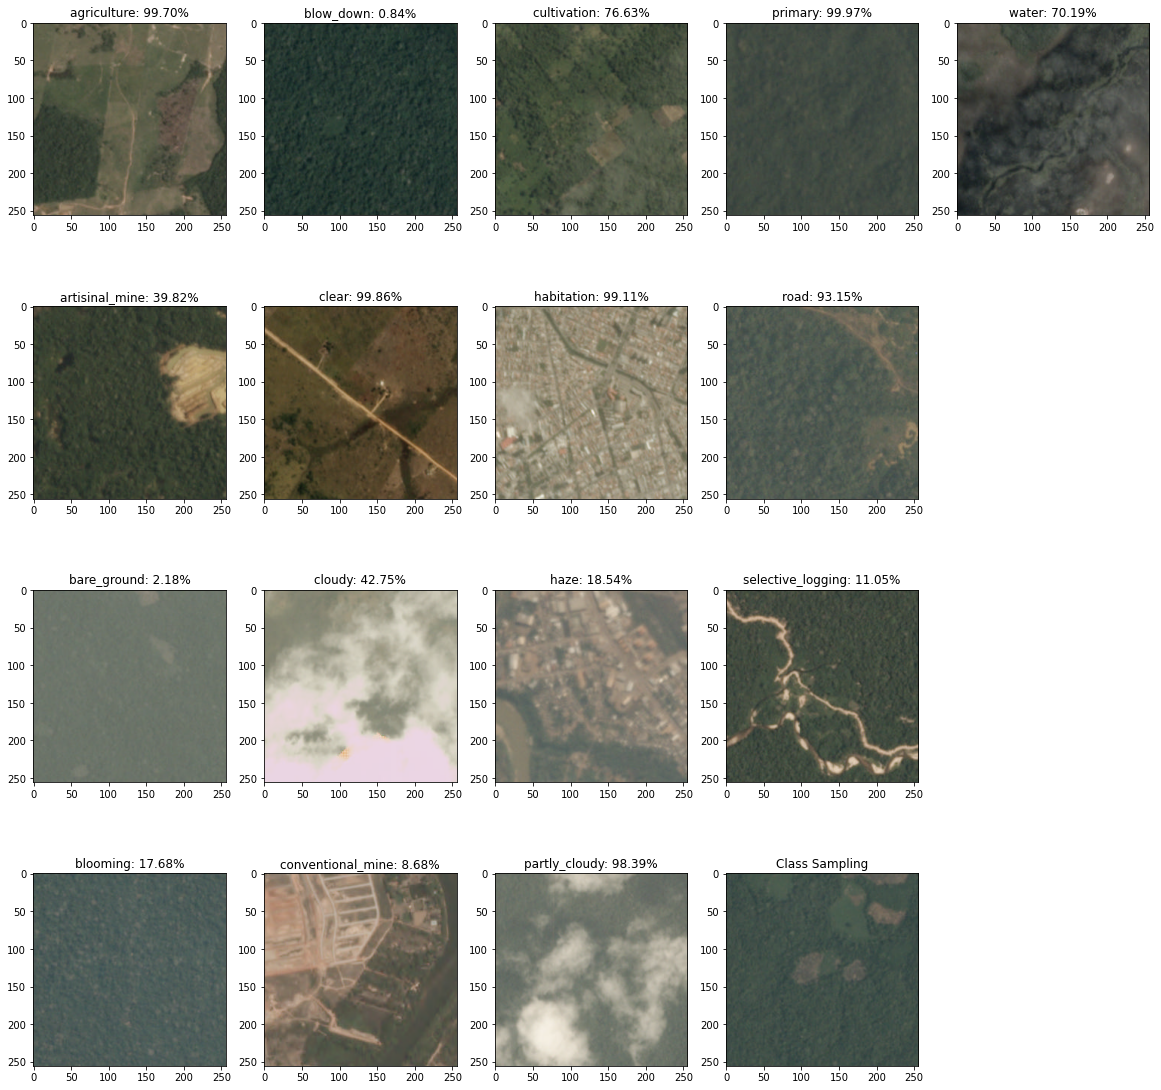

<Figure size 432x288 with 0 Axes>

In [ ]:
N_tags = len(classes)
fig, axes = plt.subplots(4, (N_tags//4)+1, figsize=(20, 20))
for idx, tag in enumerate(classes):
    filename = df_val.loc[df_val.tags.str.contains(tag)].image_name.values[idx]
    img = Image.open(os.path.join(path_train, filename+".jpg")).convert("RGB")
    X = transform_val(img)[None, :]
    sample_pred = model(X.to(device)).detach().numpy()
    y_classes = classify(sample_pred)
    _, index_class = np.where(y_classes == 1)
    legend = ""
    for i in index_class:
      legend = legend + f"{classes[i]}: {sample_pred[0][i]*100:2.2f}% \n"
    legend = f'{classes[idx]}: {sample_pred[0][idx]*100:2.2f}%'
    idx_col = idx // 4
    idx_row = idx % 4
    axes[idx_row][idx_col].set_title(legend)
    axes[idx_row][idx_col].imshow(img)
axes[1][-1].remove()
axes[2][-1].remove()
axes[3][-1].remove()
title = 'Class Sampling'
plt.title(title)
plt.show()
plt.savefig(experiment_results+title+".jpg")

In [ ]:
y_true = results['y']['val']['label'][best_epoch].reshape((-1,FEATURES)).numpy()
y_pred = results['y']['val']['pred'][best_epoch].reshape((-1,FEATURES)).numpy()

fig1 = go.Figure()
fig1.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1, name='no_skill'
)

fig2 = go.Figure()
fig2.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=0
)
pr_auc = pd.DataFrame()
roc_auc = pd.DataFrame()
for i in range(y_true.shape[1]):
    y_true_class = y_true[:, i]
    y_pred_class = y_pred[:, i]

    precision, recall, fbeta, support = precision_recall_fscore_support(y_true_class, y_pred_class>0.2, average='binary')
    precision, recall, thresholds= precision_recall_curve(y_true_class, y_pred_class)
    pr_auc = auc(recall, precision)
    no_skill_score = y_true_class.sum()/y_true_class.size
    name = f"{classes[i]} \n (AUC={fbeta:.3f}, no-skill={no_skill_score:.3f})"
    fig2.add_trace(go.Scatter(x=recall, y=precision, name=name, mode='lines'))

    fpr, tpr, _ = roc_curve(y_true_class, y_pred_class)
    auc_score = roc_auc_score(y_true_class, y_pred_class, average='macro')
    name = f"{classes[i]} \n (AUC={auc_score:.3f})"
    fig1.add_trace(go.Scatter(x=fpr, y=tpr, name=name, mode='lines'))

fig1.add_trace(go.Scatter(x=[0,1], y=[0,1], name="no-skill (AUC=0.5)", mode='lines'))    

title = 'ROC Curve All Classes'
fig1.update_layout(
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    #yaxis=dict(scaleanchor="x", scaleratio=1),
    xaxis=dict(constrain='domain'),
    width=800, height=600,
    title = 'ROC Curve'
)
fig2.write_image(experiment_results+title+".jpg")
fig1.show()
fig2.update_layout(
    yaxis_title='Precision',
    xaxis_title='Recall',
    #yaxis=dict(scaleanchor="x", scaleratio=1),
    xaxis=dict(constrain='domain'),
    width=800, height=600,
    title = 'PR Curve'
)
title = 'PR Curve All Classes'
fig2.write_image(experiment_results+title+".jpg")
fig2.show()


In [ ]:
if RunningInCOLAB:
    #files.download(results_path)
    #files.download(checkpoint_path)
    #!sleep 600
    #runtime.unassign()
    pass